In [1]:
import sys

sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.pricing_engine import LoanPricingEngine

# Load the Engine
engine = LoanPricingEngine(
    risk_model_path="../models/risk_model_xgb.pkl",
    elasticity_model_path="../models/elasticity_model_logit.pkl",
    cost_of_funds=0.04,
)

print("✅ Engine Loaded. Starting System Validation...")

✅ Engine Loaded. Starting System Validation...


c:\Users\parth\miniconda3\envs\pricing_engine\lib\pickle.py:1718: UserWarning: [18:45:33] WARNING: C:\miniconda3\conda-bld\xgboost-split_1764761400759\work\src\gbm\../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


## 1. The "Risk Monotonicity" Check
> Does the engine charge risky people more? (Sanity Check)


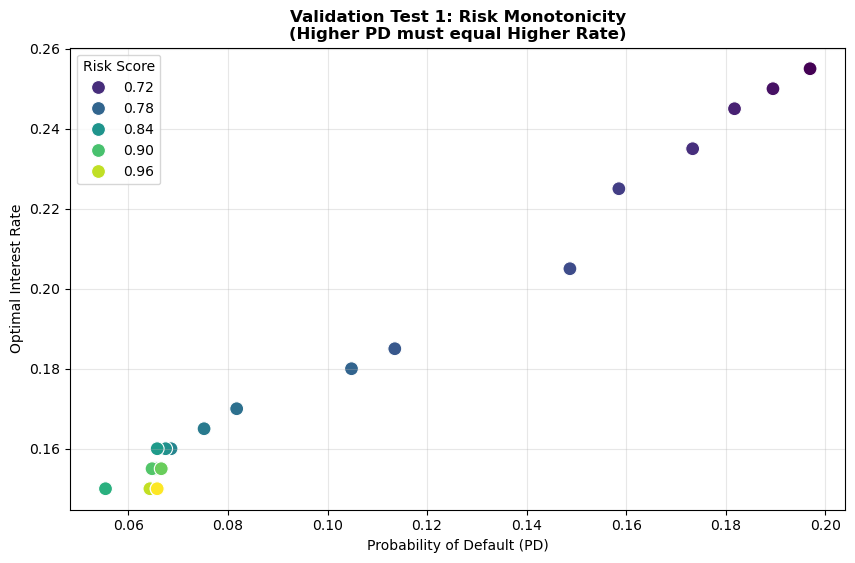

Correlation between PD and Rate: 0.9937
✅ PASS: Strong positive correlation between Risk and Price.


In [ ]:
risk_scores = np.linspace(0.30, 0.99, 50)  # From High Risk (0.3) to Super Prime (0.99)

test_batch = []
for score in risk_scores:
    test_batch.append(
        {
            "risk_score_norm": score,
            "annual_inc": 80000,
            "dti": 0.20,
            "LoanOriginalAmount": 15000,
            "revol_util": 30,  # Standardize
            "term_years": 3,
            "emp_length": 5,
            "home_ownership_RENT": 1,
            "purpose_debt_consolidation": 1,
            "total_acc": 15,
            "inq_last_6mths": 0,
        }
    )

results = []
for app in test_batch:
    res = engine.get_optimal_rate(app)
    results.append(
        {
            "Risk Score": app["risk_score_norm"],
            "PD": res["prob_default"],
            "Optimal Rate": res["optimal_rate"],
            "Decision": res["decision"],
            "Profit": res["max_profit"],
        }
    )

df_risk = pd.DataFrame(results)


plt.figure(figsize=(10, 6))

df_approved = df_risk[df_risk["Decision"] == "APPROVE"]

sns.scatterplot(
    data=df_approved,
    x="PD",
    y="Optimal Rate",
    hue="Risk Score",
    palette="viridis",
    s=100,
)
plt.title(
    "Validation Test 1: Risk Monotonicity\n(Higher PD must equal Higher Rate)",
    fontweight="bold",
)
plt.xlabel("Probability of Default (PD)")
plt.ylabel("Optimal Interest Rate")
plt.grid(True, alpha=0.3)
plt.show()

correlation = df_approved["PD"].corr(df_approved["Optimal Rate"])
print(f"Correlation between PD and Rate: {correlation:.4f}")
if correlation > 0.9:
    print("✅ PASS: Strong positive correlation between Risk and Price.")
else:
    print("❌ FAIL: Pricing is not strictly following risk.")

We see a clear "up-and-to-the-right" curve. If the line is flat or goes down, the Risk Model isn't influencing the price heavily enough.

## 2. The "Elasticity/Margin" Check

>Are we capturing the 'Stickiness' premium of Near-Prime customers?


     Segment   Rate  Risk Cost  Net Margin
0   Subprime  0.240     0.1185      0.0815
1  NearPrime  0.255     0.1185      0.0965
2      Prime  0.150     0.0371      0.0729


C:\Users\parth\AppData\Local\Temp\ipykernel_27924\1808522533.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_margin, x="Segment", y="Net Margin", palette="Blues")


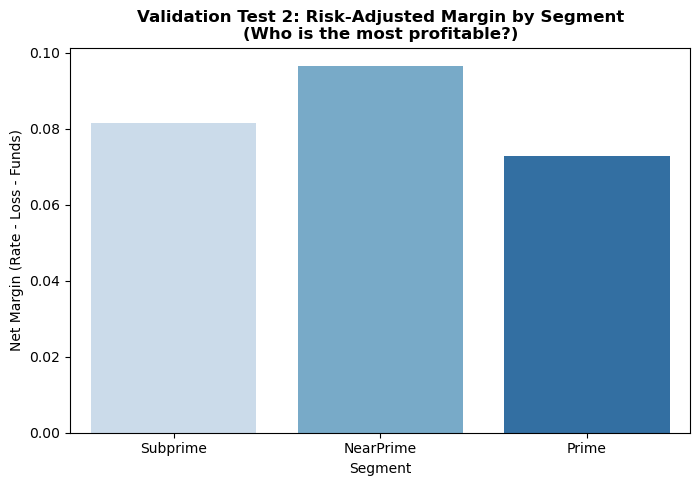

In [ ]:
profiles = [
    {"name": "Subprime", "score": 0.35, "util": 20},  # Sensitive (Affordability)
    {"name": "NearPrime", "score": 0.65, "util": 20},  # Sticky (Inelastic)
    {"name": "Prime", "score": 0.95, "util": 20},  # Competitive (Elastic)
]

margin_results = []

for p in profiles:
    # Build Input
    app = {
        "risk_score_norm": p["score"],
        "annual_inc": 65000,
        "dti": 0.25,
        "LoanOriginalAmount": 15000,
        "revol_util": p["util"],
        "term_years": 3,
        "emp_length": 5,
        "home_ownership_RENT": 1,
        "purpose_debt_consolidation": 1,
        "total_acc": 20,
        "inq_last_6mths": 0,
    }

    decision = engine.get_optimal_rate(app)

    if decision["decision"] == "APPROVE":
        rate = decision["optimal_rate"]
        pd_val = decision["prob_default"]
        exp_loss_rate = pd_val * engine.lgd

        # Pure Margin (What the bank keeps above risk cost)
        risk_adjusted_margin = rate - exp_loss_rate - engine.cost_of_funds

        margin_results.append(
            {
                "Segment": p["name"],
                "Rate": rate,
                "PD": pd_val,
                "Risk Cost": exp_loss_rate,
                "Net Margin": risk_adjusted_margin,
            }
        )

df_margin = pd.DataFrame(margin_results)
print(df_margin[["Segment", "Rate", "Risk Cost", "Net Margin"]].round(4))

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(data=df_margin, x="Segment", y="Net Margin", palette="Blues")
plt.title(
    "Validation Test 2: Risk-Adjusted Margin by Segment\n(Who is the most profitable?)",
    fontweight="bold",
)
plt.ylabel("Net Margin (Rate - Loss - Funds)")
plt.show()

* Near-Prime should ideally have the highest Net Margin. They are the "cash cows."

* Prime will have low Net Margin (because you have to lower rates to compete).

* Subprime might show high margin if approved, but often gets rejected.

## 3. Convexity Check (The "Profit Hill")

>Does the optimizer find a true global maximum, or is the curve noisy?

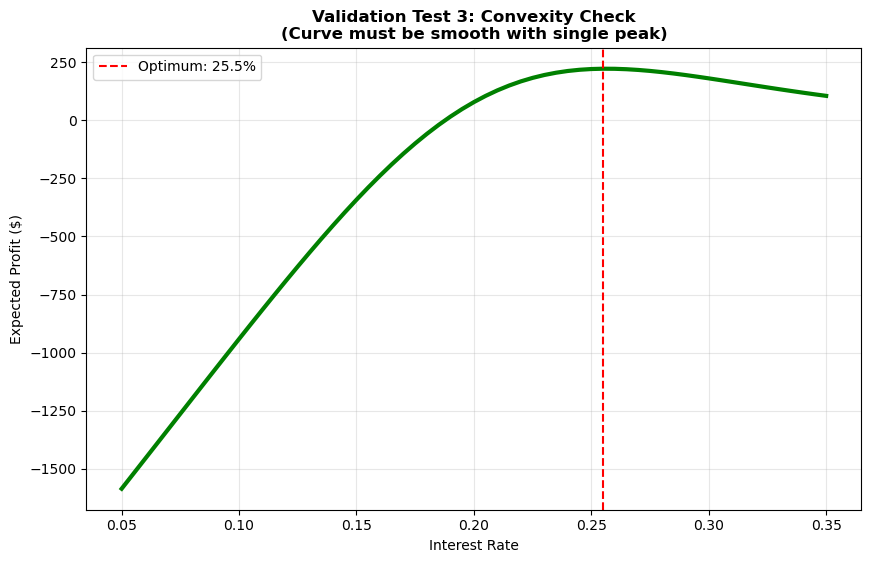

✅ PASS: Profit curve is convex (Single Peak). Optimization is stable.


In [7]:
test_app = {
    "risk_score_norm": 0.65,
    "annual_inc": 65000,
    "dti": 0.25,
    "LoanOriginalAmount": 15000,
    "revol_util": 20,
    "term_years": 3,
    "emp_length": 5,
    "home_ownership_RENT": 1,
    "purpose_debt_consolidation": 1,
    "total_acc": 20,
    "inq_last_6mths": 0,
}

decision = engine.get_optimal_rate(test_app)
curve = decision["curve_data"]

plt.figure(figsize=(10, 6))
sns.lineplot(x="Rate", y="Exp_Profit", data=curve, linewidth=3, color="green")
plt.title(
    "Validation Test 3: Convexity Check\n(Curve must be smooth with single peak)",
    fontweight="bold",
)
plt.axvline(
    decision["optimal_rate"],
    color="red",
    linestyle="--",
    label=f"Optimum: {decision['optimal_rate']:.1%}",
)
plt.xlabel("Interest Rate")
plt.ylabel("Expected Profit ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Mathematical check for multiple peaks
# We check if the derivative changes sign more than once (ignoring small noise)
peaks = 0
profits = curve["Exp_Profit"].values
for i in range(1, len(profits) - 1):
    if profits[i - 1] < profits[i] and profits[i] > profits[i + 1]:
        peaks += 1

if peaks == 1:
    print("✅ PASS: Profit curve is convex (Single Peak). Optimization is stable.")
else:
    print(f"⚠️ WARNING: Found {peaks} peaks. Optimization might be unstable.")

A "jagged" line or a double hump makes the Synthetic Data generation (Elasticity) too noisy, or the sample size too small. A smooth hill confirms the system is robust.

## 4. Edge Case Stress Test (Boundary Conditions)
>Does the model crash or behave weirdly at the extremes?

In [ ]:
edge_cases = [
    # 1. The Perfect Borrower (Does rate go to floor?)
    {"name": "Perfect", "score": 0.99, "inc": 200000, "util": 0, "dti": 0.05},
    # 2. The Bankruptcy Candidate (Does it reject?)
    {"name": "Bankrupt", "score": 0.20, "inc": 20000, "util": 100, "dti": 0.60},
    # 3. The "Whale" (Huge Loan, High Income - Does loan amount impact rate?)
    {
        "name": "Whale",
        "score": 0.80,
        "inc": 500000,
        "util": 10,
        "dti": 0.10,
        "amt": 40000,
    },
]

print("--- Edge Case Report ---")
for case in edge_cases:
    app = {
        "risk_score_norm": case["score"],
        "annual_inc": case["inc"],
        "dti": case["dti"],
        "LoanOriginalAmount": case.get("amt", 15000),  # Default if not specified
        "revol_util": case["util"],
        # Defaults
        "term_years": 3,
        "emp_length": 5,
        "home_ownership_RENT": 1,
        "purpose_debt_consolidation": 1,
        "total_acc": 20,
        "inq_last_6mths": 0,
    }

    res = engine.get_optimal_rate(app)
    print(
        f"User: {case['name']:<10} | Decision: {res['decision']:<10} | Rate: {res['optimal_rate']:.1%} | PD: {res['prob_default']:.1%}"
    )

--- Edge Case Report ---
User: Perfect    | Decision: APPROVE    | Rate: 15.0% | PD: 6.4%
User: Bankrupt   | Decision: REJECT_RISK | Rate: 0.0% | PD: 20.0%
User: Whale      | Decision: APPROVE    | Rate: 15.5% | PD: 8.5%


Model does not crash or behave wierdly with edge cases